# Build ratios of tectonic region areas over total planet area 
This code computes the surface ratio from any point on the planet, i.e., any source location, up to a given distance on a sphere. This is used to determine how many venusquakes can be triggered in a given radius from a balloon.

In [95]:
import surface_ratios_module as srm
from importlib import reload
import os
reload(srm)

R0 = 6052000
lon_0, lat_0 = 0., -89.
opt_maps = dict(
    folder_TL_data='./data/TL_data/', 
    lat_0=lat_0, 
    lon_0=lon_0, 
    R0=R0
)
polygon_map, surface1_lon, surface1_lat, n_subshapes = srm.compute_map_and_TL(**opt_maps)

PATH_VENUS_DATA = os.path.join("./data/")
l_unioned_linestring = srm.load_tectonic_iris_shp(PATH_VENUS_DATA, polygon_map, epsilon=1e-1, lat_0=-89., lon_0=0., R0=6052000)

Processing corona
Split linestrings crossing antimeridian


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/geopandas/geoseries.py:844: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if s.type.startswith("Multi") or s.type == "GeometryCollection":


Buffering linestrings into polygons


/staff/quentin/Documents/Projects/2024_Venus_Detectability/surface_ratios_module.py:185: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wrinkle_ridges['geometry'] = wrinkle_ridges.geometry.buffer(epsilon)


Trim polygons with values beyond -180, 180
Project polygons to 2d map
Converting list of polygons into multipolygon
Processing rift
Split linestrings crossing antimeridian


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/geopandas/geoseries.py:844: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if s.type.startswith("Multi") or s.type == "GeometryCollection":
/staff/quentin/Documents/Projects/2024_Venus_Detectability/surface_ratios_module.py:185: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wrinkle_ridges['geometry'] = wrinkle_ridges.geometry.buffer(epsilon)


Buffering linestrings into polygons
Trim polygons with values beyond -180, 180
Project polygons to 2d map
Converting list of polygons into multipolygon
Processing ridge
Split linestrings crossing antimeridian


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/geopandas/geoseries.py:844: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if s.type.startswith("Multi") or s.type == "GeometryCollection":


Buffering linestrings into polygons
Trim polygons with values beyond -180, 180
Project polygons to 2d map


/staff/quentin/Documents/Projects/2024_Venus_Detectability/surface_ratios_module.py:185: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wrinkle_ridges['geometry'] = wrinkle_ridges.geometry.buffer(epsilon)


Converting list of polygons into multipolygon


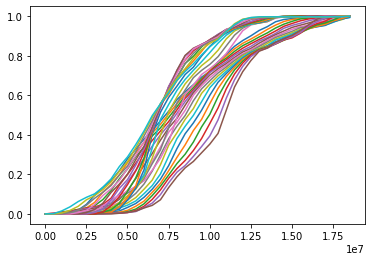

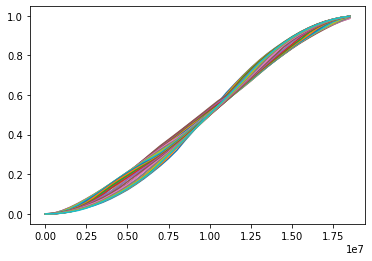

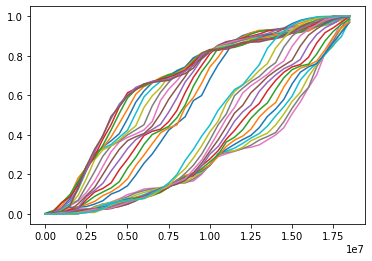

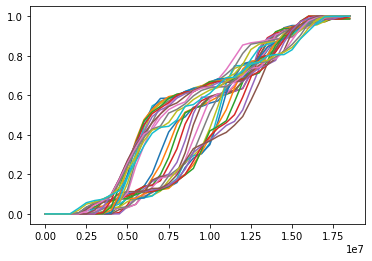

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

regions = ['rift', 'intraplate', 'ridge', 'corona']

all_data = pd.DataFrame()
for region in regions:
    
    file = f'./data/surface_ratios_{region}_active.csv'
    data = pd.read_csv(file, header=[0])
    data['region'] = region
    iloc = -1
    for (lon, lat), group in data.groupby(['lon', 'lat']):
        iloc += 1
        data.loc[data.index.isin(group.index), 'iloc'] = iloc

    plt.figure()
    for i in range(20,50):
        group = data.loc[data['iloc']==i]
        plt.plot(group.radius, group.ratio_map)
        
    all_data = pd.concat([all_data, data])

all_data.reset_index(drop=True, inplace=True)
file = f'./data/surface_ratios_active_fixed.csv'
all_data.to_csv(file, header=True, index=False)

In [49]:
geo

In [232]:
%matplotlib widget
import pyproj
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, Point
from shapely.ops import split
from sklearn.cluster import DBSCAN
from shapely.validation import make_valid
from tqdm import tqdm
from time import time
import numpy as np
import pandas as pd
import geopandas as gpd 
import os
import matplotlib.pyplot as plt
import surface_ratios_module as srm

from importlib import reload

In [248]:
reload(srm)

PATH_VENUS_DATA = os.path.join("./data/")
unioned_linestring = srm.load_wrinkles_shp(PATH_VENUS_DATA, epsilon=0.5)

Loading shape files
Split linestrings crossing antimeridian


100%|██████████| 65869/65869 [00:58<00:00, 1118.10it/s]
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/geopandas/geoseries.py:844: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if s.type.startswith("Multi") or s.type == "GeometryCollection":


Buffering linestrings into polygons


/staff/quentin/Documents/Projects/2024_Venus_Detectability/surface_ratios_module.py:152: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  VENUS['wrinkle_ridges']['geometry'] = VENUS['wrinkle_ridges'].geometry.buffer(epsilon)


Trim polygons with values beyond -180, 180
Project polygons to 2d map
Converting list of polygons into multipolygon


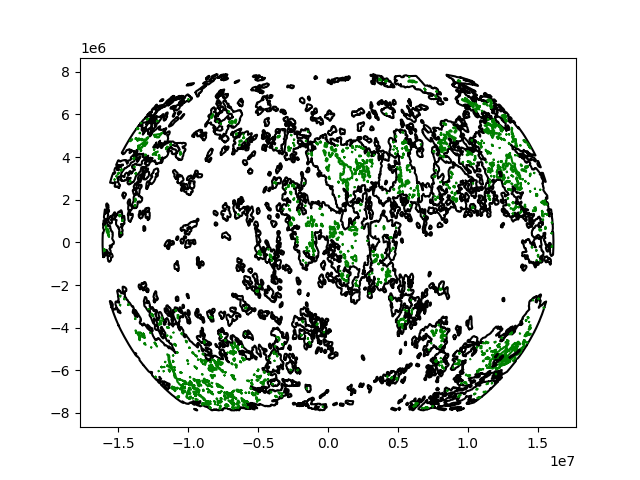

In [675]:
from matplotlib.patches import Polygon

plt.figure()

for geo in unioned_linestring.geoms:
    coords = np.array(geo.exterior.coords)
    #p = Polygon(coords, facecolor = 'k')
    plt.plot(coords[:,0], coords[:,1], color='black')
    for interior in geo.interiors:
        coords_interior = np.array(interior.coords)
        plt.plot(coords_interior[:,0], coords_interior[:,1], color='green')
    #plt.gca().add_patch(p)

In [520]:
import pyproj
from tqdm import tqdm
reload(srm)

dlat = 5
l_lon = np.arange(0, 359, dlat*2)
l_lat = np.arange(-89, 90, dlat)
LONS, LATS = np.meshgrid(l_lon, l_lat)
LONS, LATS = LONS.ravel(), LATS.ravel()
l_points = np.c_[LONS, LATS]
l_radius = np.arange(10000, np.pi*R0/1.001, 5e5)

l_points = l_points[1:2,:]
l_radius = l_radius[15:16]

R0 = 6052000
opt_coords = dict(
    l_radius = l_radius, 
    num_points = 1000,
    lon_0=0., 
    lat_0=-89., 
    R0=R0, 
    threshold=4e6, 
    s_cluster=2,
    l_points=l_points,
    nb_CPU=1
)
 
"""
opt_coords = [val for key, val in opt_coords.items()]
coords_lon, coords_lat, n_subshapes = srm.compute_coordinates_TL_one_cluster(*opt_coords, (0, l_points))
"""
coords_lon, coords_lat, n_subshapes = srm.compute_coordinates_TL_across_CPUs(**opt_coords)

Running serial


100%|██████████| 1/1 [00:00<00:00, 49.41it/s]


In [329]:
with open('./data/TL_data/coords_lon.npy', 'wb') as f: np.save(f, coords_lon)
with open('./data/TL_data/coords_lat.npy', 'wb') as f: np.save(f, coords_lat)
with open('./data/TL_data/n_subshapes.npy', 'wb') as f: np.save(f, np.array(n_subshapes))

In [655]:
reload(srm)

opt_maps = dict(
    folder_TL_data='./data/TL_data/', 
    lat_0=-89., 
    lon_0=0., 
    R0=6052000
)
polygon_map, surface1_lon, surface1_lat, n_subshapes = srm.compute_map_and_TL(**opt_maps)

In [659]:
dlat = 5
l_lon = np.arange(0, 359, dlat*2)
l_lat = np.arange(-89, 90, dlat)
LONS, LATS = np.meshgrid(l_lon, l_lat)
LONS, LATS = LONS.ravel(), LATS.ravel()
l_points = np.c_[LONS, LATS]
l_radius = np.arange(10000, np.pi*R0/1.001, 5e5)
N = 20
nb_chunks = l_points.shape[0]
step_idx = nb_chunks//N
ind = []
for i in range(N):
    idx = np.arange(i*step_idx, (i+1)*step_idx)
    if i == N-1:
        idx = np.arange(i*step_idx, nb_chunks)
    #ind += idx[-25:-1].tolist()
    ind += idx[-2:].tolist()
ind = np.array(ind)
ind_radius = np.arange(l_radius.size)[:]

In [657]:
id_error = np.arange(ind.size)
shape_init = surface1_lon.shape
surface1_lon = surface1_lon[:,ind,:][:,:,ind_radius][:,id_error,:]
surface1_lat = surface1_lat[:,ind,:][:,:,ind_radius][:,id_error,:]
n_subshapes = n_subshapes.reshape(shape_init[1:])[ind,:][:,ind_radius][id_error,:]

In [658]:
reload(srm)
proj = pyproj.Proj(proj='robin', lat_0=-89., lon_0=0., a=R0, b=R0)
opt_surface = dict(
    lon_0=0.,
    l_radius=l_radius[ind_radius],  
    proj=proj, 
    polygon_map=polygon_map, 
    polygon_region=unioned_linestring, 
    subsample_db=5, 
    buffer_line=120000, 
    threshold_neighbor_pts=20e6, 
    random_state=0,
    n_subshapes=n_subshapes,
    l_points=l_points[ind,:][id_error,:], 
    surface1_lon=surface1_lon, 
    surface1_lat=surface1_lat,
    nb_CPU=1
)
ratio_df = srm.compute_surface_ratios_wrinkles_across_CPU(**opt_surface)

Running serial
- Looping over all sensor locations


100%|██████████| 40/40 [04:04<00:00,  6.11s/it]


In [677]:
ratio_df = pd.read_csv('./data/surface_ratios_wrinkles.csv', header=[0])
ratio_df.loc[:, 'region'] = 'wrinkle_ridges'
for iloc in range(l_points.shape[0]):
    lon, lat = l_points[iloc,:]
    ratio_df.loc[(ratio_df.lat==lat)&(ratio_df.lon==lon), 'iloc'] = iloc
    lons = ratio_df.loc[(ratio_df.lat==lat)&(ratio_df.lon==lon), 'lon']
    lons[lons>180.] -= 360.
    ratio_df.loc[(ratio_df.lat==lat)&(ratio_df.lon==lon), 'lon'] = lons
    
ratio_df.to_csv('./data/surface_ratios_wrinkles_fixed.csv', header=True, index=False)

## Tests

8417276.888951637


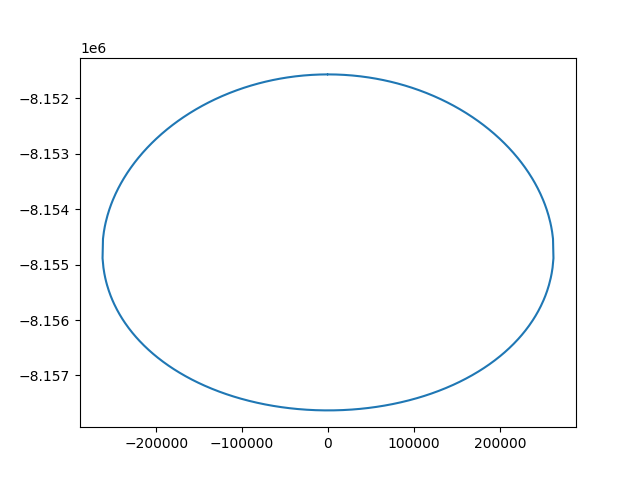

In [646]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
coords_poly1 = np.c_[surface1_lon[:,0,0], surface1_lat[:,0,0]]
coords_poly1_fixed = scaler.fit_transform(coords_poly1)
clustering = GaussianMixture(n_components=1, n_init=14, covariance_type='full', random_state=0).fit_predict(coords_poly1_fixed)

plt.figure()
#plt.scatter(coords_poly1_fixed[:,0], coords_poly1_fixed[:,1])
max_dx = 0.
for label in np.unique(clustering):
    coords_loc = coords_poly1[clustering==label][:-1]
    plt.plot(coords_loc[:,0], coords_loc[:,1])
    max_dx = max(max_dx, abs(np.diff(coords_loc)).max())
    print(max_dx)

## Load tectonic regions of Venus

In [ ]:
PATH_VENUS_DATA = os.path.join("./data/")

In [ ]:
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}Venus_data/tectonic_settings_Venus")
VENUS = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp")
}
if not do_wrinkles:
    VENUS['intraplate'] = compute_region_intraplate(VENUS, polygon_map, proj)

In [ ]:
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}wrinkle_ridges")
VENUS = {
    'wrinkle_ridges': gpd.read_file(f"{PATH_VENUS}/wrinkle_ridges.shp"),
}

# Define the custom CRS using the WKT string
venus_crs = """
GEOGCS["GCS_Venus",
    DATUM["D_Venus",
        SPHEROID["S_Venus",6051800,0]],
    PRIMEM["Reference_Meridian",0],
    UNIT["degree",0.0174532925199433],
    AXIS["Longitude",EAST],
    AXIS["Latitude",NORTH]]
"""

# Set the custom CRS to the GeoDataFrame
VENUS['wrinkle_ridges'].set_crs(venus_crs, inplace=True)

## Compute surface ratios

In [ ]:
# Define the custom CRS using the WKT string
venus_crs_0 = """
GEOGCS["GCS_Venus",
    DATUM["D_Venus",
        SPHEROID["S_Venus",6051800,0]],
    PRIMEM["Reference_Meridian",0],
    UNIT["degree",0.0174532925199433],
    AXIS["Longitude",EAST],
    AXIS["Latitude",NORTH]]
"""

venus_crs_180 = """
GEOGCS["GCS_Venus",
    DATUM["D_Venus",
        SPHEROID["S_Venus",6051800,0]],
    PRIMEM["Reference_Meridian",180],
    UNIT["degree",0.0174532925199433],
    AXIS["Longitude",EAST],
    AXIS["Latitude",NORTH]]
"""

antimeridian = LineString([(0, -90), (0, 90)])

test = VENUS['wrinkle_ridges'].copy()

epsilon = 1e-4
for ii, geo in tqdm(test.iterrows(), total=test.shape[0]):
    coords = np.array(geo.geometry.coords)
    if abs(np.diff(coords[:,0])[0]) > 180:
        #print(ii)
        test_loc = test.iloc[ii:ii+1].geometry.to_crs(venus_crs_180).iloc[0]
        split_polygons = split(test_loc, antimeridian)
        geoms = []
        for geom in split_polygons.geoms: # MultiLineString
            coords_loc = np.array(geom.coords)
            idx = np.argmax(abs(coords_loc[:,0]))
            idx_other = np.argmin(abs(coords_loc[:,0]))
            sign_found = np.sign(coords_loc[idx,0])
            coords_loc[idx_other,0] = sign_found*epsilon
            geoms.append( LineString(coords_loc) )
        geoms = MultiLineString(geoms)
        test.loc[test.index.isin([ii]),'geometry'] = geoms
        test.loc[test.index.isin([ii]),'geometry'] = test.loc[test.index.isin([ii]),'geometry'].to_crs(venus_crs_180)
VENUS['wrinkle_ridges'] = test.explode(ignore_index=True)

#VENUS['wrinkle_ridges']['geometry'] = VENUS['wrinkle_ridges'].geometry.buffer(epsilon-0.01)

In [ ]:
VENUS['wrinkle_ridges']['geometry'] = VENUS['wrinkle_ridges'].geometry.buffer(1e-2)

In [ ]:
# Function to apply the projection to a geometry
def trim_polygons(polygon):
    
    antimeridian = LineString([(-180, -90), (-180, 90)])
    meridian = LineString([(180, -90), (180, 90)])
    coords = np.array(polygon.exterior.coords) 
    
    if coords.min() < -180.:
    
        geoms = split(polygon, antimeridian).geoms
        idx_keep_antimeridian = 0
        l_antimeridian = len(geoms)
        for igeom, geom in enumerate(geoms):
            coords = np.array(geom.exterior.coords)
            if coords[:,0].min() >= -180.:
                idx_keep_antimeridian = igeom
                
        polygon = geoms[idx_keep_antimeridian]
                
    elif coords.max() > 180.:
            
        geoms = split(polygon, meridian).geoms
        idx_keep_meridian = 0
        l_meridian = len(geoms)
        for igeom, geom in enumerate(geoms):
            coords = np.array(geom.exterior.coords)
            if coords[:,0].max() <= 180.:
                idx_keep_meridian = igeom
            
        polygon = geoms[idx_keep_meridian]
    
    return polygon

# Apply the projection to each geometry in the GeoDataFrame
test = VENUS['wrinkle_ridges']['geometry'].apply(lambda geom: trim_polygons(geom))

In [ ]:
import geopandas as gpd
from shapely.ops import transform
import pyproj

# Define the projection
#R0 = 6371000  # Earth's radius in meters (or appropriate value for your context)
R0=6052000
proj = pyproj.Proj(proj='robin', lat_0=-89., lon_0=0., a=R0, b=R0)
project = pyproj.Transformer.from_proj(pyproj.Proj(proj='latlong'), proj, always_xy=True).transform
lons = np.linspace(-180., 180., 100000)
x, y = proj(lons, np.zeros_like(lons))
diff_x = abs(x.max()-x.min())

# Function to apply the projection to a geometry
def project_geometry(geometry):
    coords_init = np.array(geometry.exterior.coords)
    poly = transform(project, geometry)
    coords = np.array(poly.exterior.coords)
    if ~poly.is_valid:
        poly = make_valid(poly)
        """
        coords = np.array(make_valid(poly).exterior.coords)
        print(coords)
        plt.figure()
        plt.scatter(coords[:,0], coords[:,1], c=np.arange(coords.shape[0]))
        """
        
    if coords_init[:,0].min() < -180. or coords_init[:,0].max() > 180.:
        print('less than -180', coords_init[:,0].min(), coords_init[:,0].max())
        
    diff_poly = abs(np.diff(coords[:,0])).max()
    if diff_poly > diff_x:
        print(f'diff too large {diff_poly:.2f} > {diff_x:.2f}')
        print(coords_init[:,0])
        print(coords_init[:,1])
        
    return poly

# Apply the projection to each geometry in the GeoDataFrame
#test = VENUS['wrinkle_ridges']['geometry'].apply(lambda geom: project_geometry(geom))
test2 = test.apply(lambda geom: project_geometry(geom))

In [ ]:
from shapely.ops import unary_union

#test2['is_valid'] = test2.geometry.apply(lambda geom: geom.is_valid)
unioned_linestring = unary_union(test2.geometry)

In [ ]:
def compute_whole_map_region(lon_0, proj, dlon=10., dlat=10.): 

    left_lon  = -180
    right_lon = 180.
    bottom_lat = -90.#+lat_0 if lat_0 > 0 else 90+lat_0
    top_lat = 90.#+lat_0 if lat_0 < 0 else -90+lat_0
    
    coords_map = [proj(lon, bottom_lat) for lon in np.arange(left_lon, right_lon+dlon, dlon)]
    coords_map += [proj(right_lon, lat) for lat in np.arange(bottom_lat, top_lat+dlat, dlat)]
    coords_map += [proj(lon, top_lat) for lon in np.arange(right_lon, left_lon-dlon, -dlon)]
    coords_map += [proj(left_lon, lat) for lat in np.arange(top_lat, bottom_lat-dlat, -dlat)]
    polygon_map = Polygon(coords_map)
    return polygon_map, coords_map

polygon_map, coords_map = compute_whole_map_region(l_points[0][0], proj, dlon=1., dlat=1)

In [ ]:
plt.figure()

for geo in unioned_linestring.geoms:
    coords = np.array(geo.exterior.coords)
    plt.plot(coords[:,0], coords[:,1], color='black')

#plt.scatter(x, y, s=5, color='black')
coords = np.array(polygon_map.exterior.coords)
plt.plot(coords[:,0], coords[:,1])

In [ ]:
def spherical_cap_boundary(lat_0, lon_0, radius, R0, num_points=100):
    """
    Compute a list of latitude, longitudes corresponding to the boundary of a spherical cap.

    Parameters:
    lat_0, lon_0: Center of the spherical cap in degrees.
    radius: Radius of the spherical cap in meters.
    R0: Radius of the sphere in meters.
    num_points: Number of points to generate along the boundary.

    Returns:
    A list of (lat, lon) tuples representing the boundary of the spherical cap.
    """
    # Convert the center coordinates to radians
    lat_0_rad = np.radians(lat_0)
    lon_0_rad = np.radians(lon_0)

    # Compute the angular radius of the cap
    angular_radius = radius / R0

    # Generate a list of angles
    angles = np.linspace(0, 2*np.pi, num_points)

    # Compute the latitude and longitude of each point on the boundary
    lat_rad = np.arcsin(np.sin(lat_0_rad)*np.cos(angular_radius) + np.cos(lat_0_rad)*np.sin(angular_radius)*np.cos(angles))
    lon_rad = lon_0_rad + np.arctan2(np.sin(angles)*np.sin(angular_radius)*np.cos(lat_0_rad), np.cos(angular_radius) - np.sin(lat_0_rad)*np.sin(lat_rad))

    # Convert the coordinates back to degrees
    lat = np.degrees(lat_rad)
    lon = np.degrees(lon_rad)
    #lon[lon < 0] += 360.

    # Combine the latitude and longitude into a list of tuples
    boundary = list(zip(lon, lat))

    return boundary

def spherical_cap_boundary_v2(g, lat_0, lon_0, radius, num_points=100):

    n_radius = len(l_radius)
    lat, lon = np.repeat(lat_0, n_radius*num_points), np.repeat(lon_0, n_radius*num_points)
    angles = np.linspace(1., 359., n_radius*num_points)
    R = np.repeat(l_radius, num_points)
    endlon, endlat, _ = g.fwd(lon, lat, angles, R)

    return list(zip(endlon, endlat))

from scipy import interpolate

def resample_trajectory(proj, shape_init, lon_0, lon_loc, lon_traj, lat_traj, n_loc, n_radius, num_points_init, num_points):
    
    lon_traj_r, lat_traj_r = lon_traj.reshape(shape_init), lat_traj.reshape(shape_init)
    lon_loc_r = lon_loc.reshape(shape_init)
    
    n_subshapes = []
    #icoords = np.arange(lon_traj.size)
    #icoords_new = np.arange(n_loc*n_radius*num_points)
    #new_coords = np.zeros((icoords_new.size,2))
    new_coords_lat = np.zeros((num_points,)+lon_traj_r.shape[1:])
    new_coords_lon = np.zeros((num_points,)+lon_traj_r.shape[1:])
    print('- resampling TL boundaries')
    for iloc in tqdm(range(n_loc)):
        #icoords_loc = icoords[iloc*num_points_init*n_radius:(iloc+1)*num_points_init*n_radius]
        #icoords_loc_new = icoords_new[iloc*num_points*n_radius:(iloc+1)*num_points*n_radius]
        #lon_0_current = lon_loc[icoords_loc[0]]
        lon_0_current = lon_loc_r[0,iloc,0]
        proj_sensor = proj(lon_0_current, 0.)
        proj_sensor_ref = proj(lon_0, 0.)
        offset = abs(proj_sensor_ref[0]-proj_sensor[0])
        #print(f'offset: {offset} | lon_0_current: {lon_0_current}')

        for iradius in range(n_radius):
            
            #print(f'Radius: {iradius}')
            
            #icoords_loc_loc = icoords_loc[iradius*num_points_init:(iradius+1)*num_points_init]
            #icoords_loc_loc_new = icoords_loc_new[iradius*num_points:(iradius+1)*num_points]
            #trajectory = np.c_[lon_traj[icoords_loc_loc], lat_traj[icoords_loc_loc]]
            trajectory = np.c_[lon_traj_r[:,iloc,iradius], lat_traj_r[:,iloc,iradius]]
            ind = -np.argmax(abs(trajectory[:,0]-offset))-1
            trajectory = np.roll(trajectory, ind, axis=0)
            #print(f'- {iradius}: {ind} ({np.max(abs(trajectory[:,0]-offset))})')
            
            # Unpack the coordinates
            x, y = zip(*trajectory)
            x, y = x[:-1], y[:-1]

            # Compute the cumulative distance along the trajectory
            distance = np.cumsum(np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2))
            
            num_shapes = 1
            isep = distance.size
            threshold = 4e6
            loc_maxs = []
            #print(f'- max distance: {np.max(np.diff(distance))} (ratio: {np.max(np.diff(distance))/threshold})')
            if np.max(np.diff(distance)) > threshold:
                loc_maxs = np.where(np.diff(distance)>threshold)[0]
                dist_begin_end = np.sqrt((x[0]-x[-1])**2+(y[0]-y[-1])**2)
                #print(f'- len(loc_maxs): {len(loc_maxs)}')
                #print(f'- dist_begin_end: {dist_begin_end} (ratio: {dist_begin_end/threshold})')
                # Check if there is two shapes
                # Either two large distances between neighboring points or beginning and end of trajectory not close to each other
                if (len(loc_maxs) > 1) or ((len(loc_maxs) == 1) and (dist_begin_end > threshold)): 
                    num_shapes += 1
                    isep = np.argmax(np.diff(distance))+1
                
                if loc_maxs.size > 1:
                    ind = trajectory.size - np.max(loc_maxs) - 1
                    trajectory = np.roll(trajectory, ind, axis=0)
                    x, y = zip(*trajectory)
                    x, y = x[:-1], y[:-1]
                    distance = np.cumsum(np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2))
                    isep = np.argmax(np.diff(distance))+1
                
            #print(f'isep: {isep} | num_shapes: {num_shapes} | loc_maxs: {loc_maxs}')
                
            n_subshapes.append(num_shapes)
                
            #plt.figure()
            #plt.title(f'{isep}/{len(x)} ({num_shapes})')
            #plt.scatter(x, y, c=np.arange(len(x)), alpha=0.5)
            for ishape in range(num_shapes):
                
                # Unpack the coordinates
                if ishape == 0:
                    x, y = zip(*trajectory[:isep,:])
                else:
                    x, y = zip(*trajectory[isep:,:])
                x, y = x[:-1], y[:-1]

                #plt.plot(x, y,)
                #plt.scatter(x[0], y[0], marker='x', c='red')
                #plt.scatter(x[-1], y[-1], marker='o', facecolor=None, edgecolor='red')
            
                # Compute the cumulative distance along the trajectory
                distance = np.cumsum(np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2))

                # Normalize the distance values to be between 0 and 1
                distance = distance / distance[-1]
                
                # Perform cubic spline interpolation
                spline, u = interpolate.splprep([x, y], s=0, u=distance)
                
                #plt.figure()
                #plt.scatter(x,y)
                #plt.plot(x,y)
                
                # Compute the total length of the trajectory
                total_length = np.hypot(x[-1]-x[0], y[-1]-y[0])

                # Determine the number of points to sample
                #num_points = int(total_length / D)

                # Generate the normalized distances of the new points
                num_points_shape = num_points//num_shapes
                u_new = np.linspace(0, 1, num_points_shape)

                # Compute the new coordinates
                new_coords_loc = interpolate.splev(u_new, spline)
                #print(num_points_shape*ishape, num_points_shape*(ishape+1), icoords_loc_loc_new.shape, new_coords_loc[0].shape)
                #print(icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)].shape)
                #print(new_coords.shape)
                #print(new_coords_loc[0].shape, num_points_shape, ishape, icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)].min(), icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)].max())
                #new_coords[icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)],:] = np.c_[new_coords_loc[0], new_coords_loc[1]]
                new_coords_lon[num_points_shape*ishape:num_points_shape*(ishape+1),iloc,iradius] = new_coords_loc[0]
                new_coords_lat[num_points_shape*ishape:num_points_shape*(ishape+1),iloc,iradius] = new_coords_loc[1]
                
                #plt.axvline(x[0])
                #plt.scatter(new_coords_loc[0], new_coords_loc[1], s=10)
        
    return new_coords_lon, new_coords_lat, n_subshapes

def spherical_cap_boundary_v3(g, proj, lon_reference, l_lat_0, l_lon_0, l_radius, num_points=100):

    num_points_init = num_points*10
    n_loc = l_lat_0.size
    n_radius = len(l_radius)
    #lat, lon = np.repeat(l_lat_0, n_radius*num_points_init), np.repeat(l_lon_0, n_radius*num_points_init)
    #iloc = np.repeat(np.arange(n_loc), n_radius*num_points_init)
    l_angles = np.linspace(0., 359.9999, num_points_init)
    #angles = np.tile(l_angles, n_radius*n_loc)
    #R = np.repeat(l_radius, num_points_init*n_loc)
    
    iloc, angles, R = np.meshgrid(np.arange(n_loc), l_angles, l_radius)
    shape_init = iloc.shape
    angles, R, iloc = angles.ravel(), R.ravel(), iloc.ravel()
    lon, lat = l_lon_0[iloc], l_lat_0[iloc]
    
    endlon_deg, endlat_deg, _ = g.fwd(lon, lat, angles, R)
    endlon, endlat = proj(endlon_deg, endlat_deg)
    
    """
    dists = [0.]
    for iloc in range(1, endlon.size):
        #_, _, dist = g.inv(endlon[iloc], endlat[iloc], endlon[iloc-1], endlat[iloc-1])
        dist = np.sqrt((endlon[iloc]-endlon[iloc-1])**2 + (endlat[iloc]-endlat[iloc-1])**2)
        dists.append( dist )
    cum_dists = np.cumsum(dists)
    
    l_dists = np.linspace(0., cum_dists[-1], num_points)
    delta_dist = l_dists[1]
    endlon_new = [endlon[0]]
    endlat_new = [endlat[0]]
    for iloc in range(1, l_dists.size):
        current_dist = l_dists[iloc]
        iclosest = (np.arange(endlon.size)[cum_dists>current_dist])[0]-1
        one_endlat = np.interp(current_dist-cum_dists[iclosest], [endlon[iclosest], endlon[iclosest+1]], endlat[iclosest], endlat[iclosest+1])
    """
    coords_lon, coords_lat, n_subshapes = resample_trajectory(proj, shape_init, lon_reference, lon, endlon, endlat, n_loc, n_radius, num_points_init, num_points)
    #print(coords)
    
    return coords_lon, coords_lat, n_subshapes, endlon.reshape(shape_init), endlat.reshape(shape_init)
        
def compute_region_venus(polygon_map, ext_points, proj, show_bar=True):

    # ext_points: e.g., VENUS['rift'].exterior
    polygon2 = Polygon()
    for ext in tqdm(ext_points, disable=show_bar):
        if ext is None:
            continue
        surface2 = list(ext.coords)
        coords = np.array([proj(lon, lat) for lon, lat in surface2])
        clustering = DBSCAN(eps=500000, min_samples=5).fit(coords)
        lines = []
        #print(f'labels: {np.unique(clustering.labels_)}')
        for label in np.unique(clustering.labels_):
            #print(f'- size: {coords[clustering.labels_==label].shape[0]}')
            if coords[clustering.labels_==label].shape[0] > 1:
                lines.append( LineString(coords[clustering.labels_==label]).buffer(200000) )
        lines = MultiPolygon(lines)
        #print('lines', lines.geom_type)
        #print('polygon2', polygon2.geom_type)
        diff_map = polygon_map.difference(make_valid(lines))
        #print('diff_map', diff_map.geom_type)
        if diff_map.geom_type == 'MultiPolygon':
            ipolymax = -1
            max_val = -1
            for ipoly, sub_poly in enumerate(diff_map.geoms):
                if sub_poly.area > max_val:
                    ipolymax = ipoly
                    max_val = sub_poly.area

            for ipoly, sub_poly in enumerate(diff_map.geoms):
                if not ipoly == ipolymax:
                    continue 
                diff_map = polygon_map.difference(sub_poly)
            
            #print('diff_map2', diff_map.geom_type)
        
            diff_map = make_valid(diff_map)
            #print('diff_map3', diff_map.geom_type)
            if diff_map.geom_type == 'MultiPolygon':
                for ipoly, sub_poly in enumerate(diff_map.geoms):
                    #if ipoly == ipolymax:
                    #    continue 
                    if sub_poly.geom_type == 'Polygon':
                        #print('sub_poly', sub_poly.buffer(10))
                        polygon2 = polygon2.union( sub_poly.buffer(10) )
                    #exts.append(iext)
            else:
                #print('diff_map3 before polygon2', polygon2.geom_type)
                #bef = polygon2.geom_type
                #polygon2_bef = polygon2
                polygon2 = polygon2.union( diff_map.buffer(10) )
                #aft = polygon2.geom_type
                #if bef == 'MultiPolygon' and aft == 'GeometryCollection':
                #    return polygon2, polygon2_bef, diff_map
                #print('diff_map3 after polygon2', polygon2.geom_type)
                
        else:
            polygon2 = polygon2.union(lines)
                
    polygon2 = make_valid(polygon2)
    return polygon2

"""
def compute_whole_map_region(lon_0, proj, dlon=10., dlat=10.): 

    left_lon  = -180.01+lon_0 if lon_0 > 0 else 180.01+lon_0
    right_lon = -179.01+lon_0 if lon_0 > 0 else 179.01+lon_0
    bottom_lat = -89.9#+lat_0 if lat_0 > 0 else 90+lat_0
    top_lat = 89.9#+lat_0 if lat_0 < 0 else -90+lat_0
    
    coords_map = [proj(lon, bottom_lat) for lon in np.arange(left_lon, right_lon, dlon)]
    coords_map += [proj(right_lon, lat) for lat in np.arange(bottom_lat, top_lat, dlat)]
    coords_map += [proj(lon, top_lat) for lon in np.arange(right_lon, left_lon, -dlon)]
    coords_map += [proj(left_lon, lat) for lat in np.arange(top_lat, bottom_lat, -dlat)]
    polygon_map = Polygon(coords_map)
    return polygon_map, coords_map
"""
def compute_whole_map_region(lon_0, proj, dlon=10., dlat=10.): 

    left_lon  = -180.
    right_lon = 180.
    bottom_lat = -90.#+lat_0 if lat_0 > 0 else 90+lat_0
    top_lat = 90.#+lat_0 if lat_0 < 0 else -90+lat_0
    
    coords_map = [proj(lon, bottom_lat) for lon in np.arange(left_lon, right_lon+dlon, dlon)]
    coords_map += [proj(right_lon, lat) for lat in np.arange(bottom_lat, top_lat+dlat, dlat)]
    coords_map += [proj(lon, top_lat) for lon in np.arange(right_lon, left_lon-dlon, -dlon)]
    coords_map += [proj(left_lon, lat) for lat in np.arange(top_lat, bottom_lat-dlat, -dlat)]
    polygon_map = Polygon(coords_map)
    return polygon_map, coords_map

from sklearn.mixture import GaussianMixture

def compute_TL_region_v2(polygon_map, coords_poly1, proj, lon_0, lon_0_current, sensor, n_subshape, subsample_db=1, buffer_line=300000, buffer_sensor=180000, n_init_max=10, threshold_neighbor_pts = 5e5, random_state=1):
    
    proj_sensor = proj(lon_0_current, 0.)
    proj_sensor_ref = proj(lon_0, 0.)
    offset = abs(proj_sensor_ref[0]-proj_sensor[0])

    #coords_poly1 = np.roll(coords_poly1, -np.argmax(abs(coords_poly1[:,0]-offset))-1, axis=0)
    last_area = 0
    
    plt.figure()
    #plt.title(n_subshape)
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    coords_poly1_fixed = scaler.fit_transform(coords_poly1)
    
    diff_poly_return = None
    
    for iin, n_components in enumerate([n_subshape]):
        
        l_n_init = np.arange(1,n_init_max)
        l_covariances = ['full', 'spherical']
        NINIT, COV = np.meshgrid(l_n_init, l_covariances)
        NINIT, COV = NINIT.ravel(), COV.ravel()
        for n_init, cov in zip(NINIT, COV):
        
            #print(f'---> n_comp: {n_components} n_init: {n_init} cov: {cov}')
        
            coords = np.array(polygon_map.exterior.coords)
            plt.plot(coords[:,0], coords[:,1], label='map')
            
            plt.plot(coords_poly1[:-1,0], coords_poly1[:-1,1], label='traj')
            
            clustering = GaussianMixture(n_components=n_components, n_init=n_init, covariance_type=cov, random_state=random_state).fit_predict(coords_poly1_fixed)
            polygon1 = Polygon()
            max_dx = 0.
            for label in np.unique(clustering):
                max_dx = max(max_dx, abs(np.diff(coords_poly1[clustering==label][:-1,0])).max())
                #plt.plot(coords_poly1[clustering==label][:-1,0], coords_poly1[clustering==label][:-1,1])
                polygon1 = polygon1.union( LineString(coords_poly1[clustering==label][:-1]).buffer(buffer_line) )
            
            if max_dx > threshold_neighbor_pts: # Check for potential issues with clustering, i.e., shared points between shapes
                continue

            
            
                
            diff_poly = polygon_map.difference(polygon1.buffer(10)) # The buffer here is to avoid errors like TopologyException: Input geom 1 is invalid: Self-intersection

            #print(diff_poly.geom_type)
            if diff_poly.geom_type == 'MultiPolygon':
                
                for igeo, geo in enumerate(diff_poly.geoms):
                    coords = np.array(geo.exterior.coords)
                    plt.plot(coords[:,0], coords[:,1], label=igeo)
                plt.legend()
        
            
                areas = []
                idx_sensor = []
                for poly in diff_poly.geoms:
                    areas.append(poly.area)
                    #idx = 1 if poly.contains(sensor) else 0
                    idx_sensor.append(poly.buffer(buffer_sensor).contains(sensor))
                areas = np.array(areas)
                idx_sensor = np.array(idx_sensor)

                if np.where(idx_sensor)[0].size == 0: # Check for potential issues with clustering, i.e., sensor not in any of the shapes
                    continue
                    
                if np.where(idx_sensor)[0].size > 1: # If multiple shapes contain the sensors (because of the buffer) we select the smallest shape
                    idx_min = np.argmin(areas)
                    for idx in range(len(idx_sensor)):
                        if not idx == idx_min:
                            idx_sensor[idx] = False

                #scenario = 0
                idx_other = -1
                if len(areas) > 2:
                    if areas[np.where(idx_sensor)[0][0]] < np.max(areas):
                        #scenario = 1 # two small areas with one of them containing the sensor
                        idx_other = np.where(~idx_sensor)[0]
                        idx_other = idx_other[np.argmin(areas[idx_other])]

                polygon1 = MultiPolygon()
                cpt_area = -1
                for poly in diff_poly.geoms:
                    cpt_area += 1
                    #print(f'{cpt_area}/{len(areas)}: {poly.area}')

                    if idx_sensor[cpt_area] or (idx_other == cpt_area):
                        #print(f'- Selected {cpt_area}')
                        polygon1 = polygon1.union(poly)

            else:
                if not polygon1.contains(sensor):
                    polygon1 = diff_poly

            if (polygon1.area-last_area>1e11) or (iin == 0):
                last_area = polygon1.area
                polygon1_return = polygon1
                diff_poly_return = diff_poly
                
            break
       
    return polygon1_return, diff_poly_return

def plot_TL_map(polygon_map, polygon1, polygon2, intersection, proj, lon_0_current, lat_0_current):
    
    plt.figure()

    plt.plot(*polygon_map.exterior.xy, label='TL', color='tab:blue')
    if polygon1.geom_type == 'MultiPolygon':
        for poly in polygon1.geoms:
            plt.plot(*poly.exterior.xy, label='TL', color='tab:blue', )
    else:
        plt.plot(*polygon1.exterior.xy, label='TL', color='tab:red', )
    for poly in polygon2.geoms:
        if poly.geom_type == 'LineString':
            plt.plot(*poly.xy, label='venus', color='orange')
        else:
            plt.plot(*poly.exterior.xy, label='venus', color='orange')
            for interior in poly.interiors:
                plt.plot(*interior.xy, label='venus', color='orange')
    if intersection.geom_type == 'MultiPolygon':
        for poly in intersection.geoms:
            if poly.geom_type == 'LineString':
                plt.scatter(*poly.xy, label='inter', color='black', alpha=0.5, s=5, )
            else:
                plt.scatter(*poly.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
                for interior in poly.interiors:
                    plt.plot(*interior.xy, label='inter', color='black')
    elif intersection.geom_type == 'Polygon':
        plt.scatter(*intersection.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
        for interior in intersection.interiors:
            plt.scatter(*interior.xy, label='inter', color='black', alpha=0.5, s=5)
    x, y = proj(lon_0_current, lat_0_current)
    plt.scatter(x, y, marker='^', edgecolor='black', color='red', s=200, zorder=1000)
    plt.title(f'Surface area ratio: {intersection.area/polygon2.area:.2e}')

def compute_surface_area_ratio(intersection, polygon_map):
    return intersection.area/polygon_map.area

def compute_region_intraplate(VENUS, polygon_map, proj):

    if 'intraplate' in VENUS:
        return VENUS['intraplate']

    polygon2 = Polygon()
    for region in VENUS:
        polygon2 = polygon2.union( compute_region_venus(polygon_map, VENUS[region].exterior, proj, show_bar=False) )

    return polygon_map.difference(polygon2)

do_wrinkles = True

random_state = 1
warm_start = False
recompute_surface1 = True
istart = 2066

R0 = 6052000  # Venus' radius in meters
g = pyproj.Geod(proj='robin', lat_0=0., lon_0=0., a=R0, b=R0)    
l_radius = np.arange(10000, np.pi*R0/1.001, 500000)
#lat_0 = 30.1478  # Latitude sensor
#lon_0 = 138.1445  # Longitude sensor
dlat = 5
l_lon = np.arange(0, 359, dlat*2)
l_lat = np.arange(-89, 90, dlat)
#l_lon = np.arange(-179, 180, 1)
LONS, LATS = np.meshgrid(l_lon, l_lat)
LONS, LATS = LONS.ravel(), LATS.ravel()
l_points = list(zip(LONS, LATS))
#l_points = l_points[0:1]+l_points[2066:]
#l_points = l_points[38:]
num_points = 2000
buffer_line = 120000

#LATS = np.array([40.01010101010101, 0., -30])
#LONS = np.array([70.91919191919192, 0., -58])
#l_points = list(zip(LONS, LATS))
#LATS = LATS[[0, 189]]
#LONS = LONS[[0, 189]]
#l_points = list(zip(LONS, LATS))
#l_radius = np.array([l_radius[27]])
#l_radius = np.arange(10000, 0.2e7, 100000)
#num_points = 500
#buffer_line = 90000

if not warm_start:
    proj = pyproj.Proj(proj='robin', lat_0=l_points[0][1], lon_0=l_points[0][0], a=R0, b=R0)
    if recompute_surface1:
        surface1_lon, surface1_lat, n_subshapes, surface1_lon_init, surface1_lat_init = spherical_cap_boundary_v3(g, proj, l_points[0][0], LATS, LONS, l_radius, num_points=num_points)
    polygon_map, _ = compute_whole_map_region(l_points[0][0], proj, dlon=1., dlat=1)

if not do_wrinkles:
    VENUS['intraplate'] = compute_region_intraplate(VENUS, polygon_map, proj)

if not warm_start:
    ratio_df = pd.DataFrame()
    polygon1s = []
    
if True:
    for iregion, region in enumerate(VENUS):
        
        iloc = -1
        print(f'- {region} -')
        itotal = -1
        iregion_lon0 = -1
        
        lon_0, _ = l_points[0]
        #polygon_map, _ = compute_whole_map_region(lon_0, proj, dlon=1., dlat=1)
        print('- Finding region polygons')
        if region == 'intraplate':
            polygon2 = VENUS[region]
        elif region == 'wrinkle_ridges':
            polygon2 = unioned_linestring
        else:
            polygon2 = compute_region_venus(polygon_map, VENUS[region].exterior, proj, show_bar=False)
            
        print('- Looping over all sensor locations')
        for lon_0_current, lat_0_current in tqdm(l_points):

            iloc += 1
            
            #surface1_loc = surface1[iloc*num_points*len(l_radius):(iloc+1)*num_points*len(l_radius), :]
            
            sensor = Point(proj(lon_0_current, lat_0_current))

            last_area = 0
            base_n_components = 1
            iregion_lon0 += 1
            for iradius, radius in enumerate(l_radius):

                itotal += 1
                
                print(f'itotal: {itotal} iloc: {iloc} iradius: {iradius}')
                
                if itotal < istart and warm_start:
                    continue
                
                if iregion == 0:
                    trajectory = np.c_[surface1_lon[:,iloc,iradius], surface1_lat[:,iloc,iradius]]
                    #poly, diff_poly = compute_TL_region_v2(polygon_map, surface1_loc[iradius*num_points:(iradius+1)*num_points, :], proj, lon_0, lon_0_current, sensor, n_subshapes[itotal], subsample_db=5, buffer_line=buffer_line)
                    poly, diff_poly = compute_TL_region_v2(polygon_map, trajectory, proj, lon_0, lon_0_current, sensor, n_subshapes[itotal], subsample_db=5, buffer_line=buffer_line, threshold_neighbor_pts=20e6, random_state=random_state)
                    polygon1s.append( poly )
                    intersection = polygon2.intersection(polygon1s[-1])
                else:
                    intersection = polygon2.intersection(polygon1s[itotal])
                
                ratio = compute_surface_area_ratio(intersection, polygon_map)
                ratio_map = compute_surface_area_ratio(intersection, polygon2)
                loc_dict = {'region': region, 'iloc': iloc, 'lon': lon_0_current, 'lat': lat_0_current, 'iradius': iradius, 'radius': radius, 'ratio': ratio, 'ratio_map': ratio_map}
                ratio_df = ratio_df.append([loc_dict])
                
                #plot_TL_map(polygon_map, polygon1s[itotal], polygon2, intersection, proj, lon_0_current, lat_0_current)
                #break
            #break
        #break
        
    #ratio_df.to_csv('./test_data_Venus/surface_ratios.csv', index=False, header=True)

In [ ]:
ratio_df.to_csv('./data/surface_ratios_wrinkles.csv', index=False, header=True)

In [ ]:
l_radius_ = np.arange(10000, np.pi*R0/1.001, 500000)#[iradius:iradius+2]
dlat = 20
l_lon = np.arange(0, 359, dlat*2)
l_lat = np.arange(-89, 90, dlat)
LONS_, LATS_ = np.meshgrid(l_lon, l_lat)
LONS_, LATS_ = LONS.ravel(), LATS.ravel()
#LONS_, LATS_ = LONS.ravel()[iloc:iloc+1], LATS.ravel()[iloc:iloc+1]
#LONS_, LATS_ = np.array([45.]), np.array([0.])
l_points_ = list(zip(LONS_, LATS_))
num_points = 2000

proj_ = pyproj.Proj(proj='robin', lat_0=l_points[0][1], lon_0=l_points[0][0], a=R0, b=R0)
surface1_lon_, surface1_lat_, _, _, _ = spherical_cap_boundary_v3(g, proj_, l_points[0][0], LATS_, LONS_, l_radius_, num_points=num_points)
#polygon_map, _ = compute_whole_map_region(l_points[0][0], proj, dlon=1., dlat=1)

In [ ]:
np.arange(10000, np.pi*R0/1.001, 500000)

In [ ]:
plt.figure()
iradius_ = iradius
iloc_ = iloc
offset = 0

x, y = proj(LONS[iloc], LATS[iloc])

trajectory_ = np.c_[surface1_lon_[:,iloc_,iradius_], surface1_lat_[:,iloc_,iradius_]]
plt.scatter(trajectory_[:,0], trajectory_[:,1])

trajectory_ = np.c_[surface1_lon[:,iloc,iradius+offset], surface1_lat[:,iloc,iradius+offset]]
plt.scatter(trajectory_[:,0], trajectory_[:,1])
plt.scatter(x, y, marker='*')

In [ ]:
def compute_TL_region_v2(polygon_map, coords_poly1, proj, lon_0, lon_0_current, sensor, n_subshape, random_state=1, subsample_db=1, buffer_line=300000, buffer_sensor=180000, n_init_max=10, threshold_neighbor_pts = 5e5):
    
    proj_sensor = proj(lon_0_current, 0.)
    proj_sensor_ref = proj(lon_0, 0.)
    offset = abs(proj_sensor_ref[0]-proj_sensor[0])

    #coords_poly1 = np.roll(coords_poly1, -np.argmax(abs(coords_poly1[:,0]-offset))-1, axis=0)
    last_area = 0
    plt.figure()
    display = False
    #plt.title(n_subshape)
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    coords_poly1_fixed = scaler.fit_transform(coords_poly1)
    
    for iin, n_components in enumerate([n_subshape]):
        
        l_n_init = np.arange(1,n_init_max)
        l_covariances = ['full', 'spherical']
        NINIT, COV = np.meshgrid(l_n_init, l_covariances)
        NINIT, COV = NINIT.ravel(), COV.ravel()
        for n_init, cov in zip(NINIT, COV):
        
            print(f'---> n_comp: {n_components} n_init: {n_init} cov: {cov}')
        
            clustering = GaussianMixture(n_components=n_components, n_init=n_init, covariance_type=cov, random_state=random_state).fit_predict(coords_poly1_fixed)
            n_clusters = np.unique(clustering).size
            polygon1 = Polygon()
            max_dx = 0.
            print(f'Clusters: {np.unique(clustering)}')
            for label in np.unique(clustering):
                max_dx = max(max_dx, abs(np.diff(coords_poly1[clustering==label][:-1,0])).max())
                #plt.plot(coords_poly1[clustering==label][:-1,0], coords_poly1[clustering==label][:-1,1])
                polygon1 = polygon1.union( LineString(coords_poly1[clustering==label][:-1]).buffer(buffer_line) )
            
            print(max_dx, threshold_neighbor_pts)
            if max_dx > threshold_neighbor_pts and n_clusters > 1: # Check for potential issues with clustering, i.e., shared points between shapes
                continue
            
            if display:
                coords = np.array(polygon_map.exterior.coords)
                plt.plot(coords[:,0], coords[:,1], label='map')
            
            
            diff_poly = polygon_map.difference(polygon1.buffer(10)) # The buffer here is to avoid errors like TopologyException: Input geom 1 is invalid: Self-intersection

            if diff_poly.geom_type == 'MultiPolygon':
                
                if display:
                    for geo in diff_poly.geoms:
                        coords = np.array(geo.exterior.coords)
                        plt.plot(coords[:,0], coords[:,1], )

                areas = []
                idx_sensor = []
                for poly in diff_poly.geoms:
                    areas.append(poly.area)
                    #idx = 1 if poly.contains(sensor) else 0
                    idx_sensor.append(poly.buffer(buffer_sensor).contains(sensor))
                areas = np.array(areas)
                idx_sensor = np.array(idx_sensor)

                if np.where(idx_sensor)[0].size == 0: # Check for potential issues with clustering, i.e., sensor not in any of the shapes
                    continue
                    
                if np.where(idx_sensor)[0].size > 1: # If multiple shapes contain the sensors (because of the buffer) we select the smallest shape
                    idx_min = np.argmin(areas)
                    for idx in range(len(idx_sensor)):
                        if not idx == idx_min:
                            idx_sensor[idx] = False

                #scenario = 0
                idx_other = -1
                if len(areas) > 2:
                    if areas[np.where(idx_sensor)[0][0]] < np.max(areas):
                        #scenario = 1 # two small areas with one of them containing the sensor
                        idx_other = np.where(~idx_sensor)[0]
                        idx_other = idx_other[np.argmin(areas[idx_other])]

                polygon1 = MultiPolygon()
                cpt_area = -1
                for poly in diff_poly.geoms:
                    cpt_area += 1
                    #print(f'{cpt_area}/{len(areas)}: {poly.area}')

                    if idx_sensor[cpt_area] or (idx_other == cpt_area):
                        #print(f'- Selected {cpt_area}')
                        polygon1 = polygon1.union(poly)

            else:
                if not polygon1.contains(sensor):
                    polygon1 = diff_poly

            if (polygon1.area-last_area>1e11) or (iin == 0):
                last_area = polygon1.area
                polygon1_return = polygon1
                diff_poly_return = diff_poly
                
            break

    return polygon1_return, diff_poly_return

def compute_whole_map_region(lon_0, proj, dlon=10., dlat=10.): 

    left_lon  = 360.+lon_0-179.999
    right_lon = lon_0+179.999
    bottom_lat = -90.#+lat_0 if lat_0 > 0 else 90+lat_0
    top_lat = 90.#+lat_0 if lat_0 < 0 else -90+lat_0
    
    coords_map = [proj(lon, bottom_lat) for lon in np.arange(left_lon, right_lon+dlon, dlon)]
    coords_map += [proj(right_lon, lat) for lat in np.arange(bottom_lat, top_lat+dlat, dlat)]
    coords_map += [proj(lon, top_lat) for lon in np.arange(right_lon, left_lon-dlon, -dlon)]
    coords_map += [proj(left_lon, lat) for lat in np.arange(top_lat, bottom_lat-dlat, -dlat)]
    polygon_map = Polygon(coords_map)
    return polygon_map, coords_map

lon_0, _ = l_points[0]
#polygon_map_, _ = compute_whole_map_region(lon_0, proj, dlon=1., dlat=1)
polygon1_return, diff_poly_return = compute_TL_region_v2(polygon_map, trajectory, proj, lon_0, lon_0_current, sensor, n_subshapes[itotal], subsample_db=5, buffer_line=buffer_line, threshold_neighbor_pts=20e6)
#polygon1_return, diff_poly_return = compute_TL_region_v2(polygon_map_, trajectory, proj, lon_0, lon_0_current, sensor, n_subshapes[itotal], subsample_db=5, buffer_line=buffer_line, threshold_neighbor_pts=20e6)           

coords = np.array(polygon_map.exterior.coords)
plt.plot(coords[:,0], coords[:,1])

coords = np.array(polygon1_return.exterior.coords)
plt.plot(coords[:,0], coords[:,1])

intersection = polygon2.intersection(polygon1_return)

"""
for geo in tqdm(unioned_linestring.geoms):
    coords = np.array(geo.exterior.coords)
    plt.plot(coords[:,0], coords[:,1], color='black', linewidth=3.)

x, y = proj(lon_0_current, lat_0_current)
plt.scatter(x, y, color='red', marker='*')
"""  

for geo in tqdm(intersection.geoms):
    coords = np.array(geo.exterior.coords)
    plt.plot(coords[:,0], coords[:,1], color='red')


In [ ]:
print(polygon1_return)

In [ ]:
plt.figure()
offset = -3
trajectory = np.c_[surface1_lon[:,iloc,iradius-offset], surface1_lat[:,iloc,iradius-offset]]
plt.scatter(trajectory[:,0], trajectory[:,1])

x, y = proj(lon_0_current, lat_0_current)
plt.scatter(x, y, color='red', marker='*')

## Save surface ratios to file

In [ ]:
ratio_df.to_csv('./test_data_Venus/surface_ratios_fixed.csv', index=False, header=True)

## Visualize surface ratios

In [ ]:
def compute_TL_region_v2(polygon_map, coords_poly1, proj, lon_0, lon_0_current, sensor, n_subshape, subsample_db=1, buffer_line=300000, buffer_sensor=180000, n_init_max=10, threshold_neighbor_pts = 5e5):
    
    proj_sensor = proj(lon_0_current, 0.)
    proj_sensor_ref = proj(lon_0, 0.)
    offset = abs(proj_sensor_ref[0]-proj_sensor[0])

    #coords_poly1 = np.roll(coords_poly1, -np.argmax(abs(coords_poly1[:,0]-offset))-1, axis=0)
    last_area = 0
    plt.figure()
    plt.title(n_subshape)
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    coords_poly1_fixed = scaler.fit_transform(coords_poly1)
    #plt.scatter(coords_poly1_fixed[1:-2,0], coords_poly1_fixed[1:-2,1], c=np.arange(coords_poly1_fixed[1:-2,1].size))
    
    for iin, n_components in enumerate([n_subshape]):
        
        l_n_init = np.arange(1,n_init_max)
        l_covariances = ['full', 'spherical']
        NINIT, COV = np.meshgrid(l_n_init, l_covariances)
        NINIT, COV = NINIT.ravel(), COV.ravel()
        for n_init, cov in zip(NINIT, COV):
        
            print(f'---> n_comp: {n_components} n_init: {n_init} cov: {cov}')
        
            clustering = GaussianMixture(n_components=n_components, n_init=n_init, covariance_type=cov).fit_predict(coords_poly1_fixed)
            polygon1 = Polygon()
            max_dx = 0.
            for label in np.unique(clustering):
                max_dx = max(max_dx, abs(np.diff(coords_poly1[clustering==label][:-1,0])).max())
                plt.plot(coords_poly1[clustering==label][:,0], coords_poly1[clustering==label][:,1])
                polygon1 = polygon1.union( LineString(coords_poly1[clustering==label][:]).buffer(buffer_line) )
            
            if max_dx > threshold_neighbor_pts: # Check for potential issues with clustering, i.e., shared points between shapes
                continue
            
            diff_poly = polygon_map.difference(polygon1.buffer(10)) # The buffer here is to avoid errors like TopologyException: Input geom 1 is invalid: Self-intersection

            #print(diff_poly.geom_type)
            if diff_poly.geom_type == 'MultiPolygon':

                areas = []
                idx_sensor = []
                for poly in diff_poly.geoms:
                    areas.append(poly.area)
                    #idx = 1 if poly.contains(sensor) else 0
                    idx_sensor.append(poly.buffer(buffer_sensor).contains(sensor))
                areas = np.array(areas)
                idx_sensor = np.array(idx_sensor)

                if np.where(idx_sensor)[0].size == 0: # Check for potential issues with clustering, i.e., sensor not in any of the shapes
                    continue
                    
                if np.where(idx_sensor)[0].size > 1: # If multiple shapes contain the sensors (because of the buffer) we select the smallest shape
                    idx_min = np.argmin(areas)
                    for idx in range(len(idx_sensor)):
                        if not idx == idx_min:
                            idx_sensor[idx] = False

                #scenario = 0
                idx_other = -1
                if len(areas) > 2:
                    if areas[np.where(idx_sensor)[0][0]] < np.max(areas):
                        #scenario = 1 # two small areas with one of them containing the sensor
                        idx_other = np.where(~idx_sensor)[0]
                        idx_other = idx_other[np.argmin(areas[idx_other])]

                polygon1 = MultiPolygon()
                cpt_area = -1
                for poly in diff_poly.geoms:
                    cpt_area += 1
                    #print(f'{cpt_area}/{len(areas)}: {poly.area}')

                    if idx_sensor[cpt_area] or (idx_other == cpt_area):
                        #print(f'- Selected {cpt_area}')
                        polygon1 = polygon1.union(poly)

            else:
                if not polygon1.contains(sensor):
                    polygon1 = diff_poly

            if (polygon1.area-last_area>1e11) or (iin == 0):
                last_area = polygon1.area
                polygon1_return = polygon1
                diff_poly_return = diff_poly
                
            break

    return polygon1_return, diff_poly_return

def plot_TL_map(polygon_map, polygon1, polygon2, intersection, proj, lon_0_current, lat_0_current):
    
    plt.figure()

    plt.plot(*polygon_map.exterior.xy, label='TL', color='tab:blue')
    if polygon1.geom_type == 'MultiPolygon':
        for poly in polygon1.geoms:
            plt.plot(*poly.exterior.xy, label='TL', color='tab:blue', )
    else:
        plt.plot(*polygon1.exterior.xy, label='TL', color='tab:red', )
    for poly in polygon2.geoms:
        if poly.geom_type == 'LineString':
            plt.plot(*poly.xy, label='venus', color='orange')
        else:
            plt.plot(*poly.exterior.xy, label='venus', color='orange')
            for interior in poly.interiors:
                plt.plot(*interior.xy, label='venus', color='orange')
    if intersection.geom_type == 'MultiPolygon':
        for poly in intersection.geoms:
            if poly.geom_type == 'LineString':
                plt.scatter(*poly.xy, label='inter', color='black', alpha=0.5, s=5, )
            else:
                plt.scatter(*poly.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
                for interior in poly.interiors:
                    plt.plot(*interior.xy, label='inter', color='black')
    elif intersection.geom_type == 'Polygon':
        plt.scatter(*intersection.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
        for interior in intersection.interiors:
            plt.scatter(*interior.xy, label='inter', color='black', alpha=0.5, s=5)
    x, y = proj(lon_0_current, lat_0_current)
    plt.scatter(x, y, marker='^', edgecolor='black', color='red', s=200, zorder=1000)
    plt.title(f'Surface area ratio: {intersection.area/polygon2.area:.5e}')

buffer_line = 120000
#iloc = 46
#iradius = len(l_radius)-16
#iradius -= 1
print(iradius, iloc)
itotal = iloc*len(l_radius) + iradius
print('l_radius:', l_radius[iradius])
trajectory = np.c_[surface1_lon[:,iloc,iradius], surface1_lat[:,iloc,iradius]]
sensor = Point(proj(l_points[iloc][0], l_points[iloc][1]))
poly, diff_poly = compute_TL_region_v2(polygon_map, trajectory, proj, lon_0, l_points[iloc][0], sensor, 1, subsample_db=5, buffer_line=buffer_line)
intersection = polygon2.intersection(poly)
plot_TL_map(polygon_map, poly, polygon2, intersection, proj, l_points[iloc][0], l_points[iloc][1])